In [6]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# #import personnal tools
import sys
sys.path.append('../python_tools/')
from tools import *
from tools_native import *
from tools_mapping import *

pres=(ap_bnds(k)+ap_bnds(k+1))/2 + sp*(b_bnds(k)+b_bnds(k+1))/2 

In [ ]:
import xarray as xr
import numpy as np
import os

filename='../../data/tmp_all.nc'
fileout='../../data/tmp_all_with_pres.nc'

nf=xr.open_dataset(filename)

#define k+1 vars
nf['ap_bnds_k+1']=nf['ap_bnds'][0].shift(klevp1=-1)
nf['real_ap']=(nf['ap_bnds'][0,0:79]+nf['ap_bnds_k+1'][0:79])/2

nf['b_bnds_k+1']=nf['b_bnds'][0].shift(klevp1=-1)
nf['real_b']=(nf['b_bnds'][0,0:79]+nf['b_bnds_k+1'][0:79])/2

#define empty variable pres with dimensions time, lon, lat, presnivs
# nf['pres']=(['time','presnivs','lat','lon'],np.zeros((len(nf['time']),79, len(nf['lat']),len(nf['lon']))))
# nf['pres'] = xr.DataArray(
#     np.zeros((len(nf['time']), 79, len(nf['lat']), len(nf['lon']))),
#     dims=['time', 'presnivs', 'lat', 'lon']
# )
nf['pres'] = xr.full_like(nf['t'], fill_value=0)
nf['pres'].attrs['long_name']='pressure'
nf['pres'].attrs['units']='Pa'

#add value to pres
for i in range(79):
    nf['pres'][:,i,:,:]=nf['real_ap'][i]+nf['real_b'][i]*nf['sp'][:,:,:]

#add 3 extra vars
nf['cbwc']=xr.full_like(nf['t'], fill_value=0)
nf['ciwc']=xr.full_like(nf['t'], fill_value=0)
nf['clwc']=xr.full_like(nf['t'], fill_value=0)


#drop ap, ap_bnds, b, b_bnds, ap_bnds_k+1, b_bnds_k+1, real_ap, real_b
nf=nf.drop_vars(['ap','ap_bnds','b','b_bnds','ap_bnds_k+1','b_bnds_k+1','real_ap','real_b'])
#drop dimension klevp1
nf=nf.drop_dims('klevp1')

#export to netcdf
if os.path.exists(fileout):
    os.remove(fileout)
nf.to_netcdf(fileout)

In [111]:
nf2=xr.open_dataset(fileout)
nf2

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 28, lon: 19, presnivs: 79, time: 123)
Coordinates:
  * bnds       (bnds) float32 1.0 2.0
  * lat        (lat) float32 20.28 21.55 22.82 24.08 ... 50.7 51.97 53.24 54.51
  * lon        (lon) float32 -25.0 -22.5 -20.0 -17.5 ... 12.5 15.0 17.5 20.0
  * presnivs   (presnivs) float32 1.012e+05 1.009e+05 1.007e+05 ... 5.297 1.483
  * time       (time) datetime64[ns] 2010-01-01T06:00:00 ... 2010-01-31T18:00:00
Data variables:
    q          (time, presnivs, lat, lon) float32 ...
    sp         (time, lat, lon) float32 ...
    time_bnds  (time, bnds) datetime64[ns] ...
    t          (time, presnivs, lat, lon) float32 ...
    ua         (time, presnivs, lat, lon) float32 ...
    va         (time, presnivs, lat, lon) float32 ...
    pres       (time, presnivs, lat, lon) float32 ...
    cbwc       (time, presnivs, lat, lon) float32 ...
    ciwc       (time, presnivs, lat, lon) float32 ...
    clwc       (time, presnivs, lat, lon) float32 ...
Attributes: (12/54)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    source:                     IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96;...
    institution:                Institut Pierre Simon Laplace, Paris 75252, F...
    Conventions:                CF-1.7 CMIP-6.2
    creation_date:              2018-08-05T09:24:23Z
    tracking_id:                hdl:21.14100/a6d57621-868e-4da8-9735-970d1ebe...
    ...                         ...
    variant_label:              r1i1p1f1
    realization_index:          1
    NCO:                        netCDF Operators version 5.0.1 (Homepage = ht...
    CDO:                        Climate Data Operators version 1.9.10 (https:...
    history_of_appended_files:  Wed Mar 19 15:05:45 2025: Appended file tmp_v...
    history:                    Wed Mar 19 15:05:46 2025: ncrename -O -v ps,s...

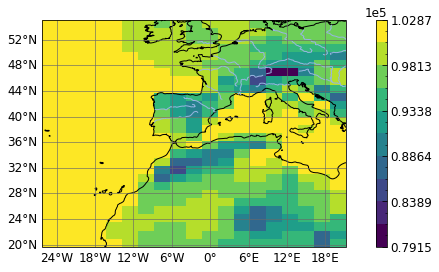

In [114]:
#plot sp for file nf
ds=nf2
presniv=0
var='pres'
plotvar=ds[var][0,presniv,:,:]
map_plotvar(plotvar)

In [ ]:
def add_pres(nf, broadcast_var, surface_pressure, add_empty_cloud_vars=True):
    #define k+1 vars
    nf['ap_bnds_k+1']=nf['ap_bnds'][0].shift(klevp1=-1)
    nf['real_ap']=(nf['ap_bnds'][0,0:79]+nf['ap_bnds_k+1'][0:79])/2

    nf['b_bnds_k+1']=nf['b_bnds'][0].shift(klevp1=-1)
    nf['real_b']=(nf['b_bnds'][0,0:79]+nf['b_bnds_k+1'][0:79])/2

    #define empty variable pres with dimensions time, lon, lat, presnivs
    nf['pres'] = xr.full_like(nf[broadcast_var], fill_value=0)
    nf['pres'].attrs['long_name']='pressure'
    nf['pres'].attrs['units']='Pa'

    #add value to pres
    for i in range(79):
        nf['pres'][:,i,:,:]=nf['real_ap'][i]+nf['real_b'][i]*nf[surface_pressure][:,:,:]

    #add 3 extra vars
    if add_empty_cloud_vars:
        nf['cbwc']=xr.full_like(nf[broadcast_var], fill_value=0)
        nf['ciwc']=xr.full_like(nf[broadcast_var], fill_value=0)
        nf['clwc']=xr.full_like(nf[broadcast_var], fill_value=0)


    #drop ap, ap_bnds, b, b_bnds, ap_bnds_k+1, b_bnds_k+1, real_ap, real_b
    nf=nf.drop_vars(['ap','ap_bnds','b','b_bnds','ap_bnds_k+1','b_bnds_k+1','real_ap','real_b'])
    #drop dimension klevp1
    nf=nf.drop_dims('klevp1')
    return(nf)

# Vertical axis and lonlatbox

In [3]:
filename='/scratchu/cheruy/PIERRE/TEST-AMIP.01_20000605_nudging_forcing.nc'
ref_nf=xr.open_dataset(filename)

ref_nf

<xarray.Dataset>
Dimensions:              (lat: 68, lon: 88, lev: 79, time_counter: 120,
                          axis_nbounds: 2)
Coordinates:
  * lat                  (lat) float64 38.12 38.38 38.62 ... 54.38 54.62 54.88
  * lon                  (lon) float64 -8.875 -8.625 -8.375 ... 12.62 12.88
  * lev                  (lev) float64 1.0 2.0 3.0 4.0 ... 76.0 77.0 78.0 79.0
    time_instant         (time_counter) object ...
  * time_counter         (time_counter) object 2000-01-01 01:00:00 ... 2000-0...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_instant_bounds  (time_counter, axis_nbounds) object ...
    time_counter_bounds  (time_counter, axis_nbounds) object ...
    u                    (time_counter, lev, lat, lon) float32 ...
    v                    (time_counter, lev, lat, lon) float32 ...
    t                    (time_counter, lev, lat, lon) float32 ...
    sp                   (time_counter, lat, lon) float32 ...
    pressure             (time_counter, lev, lat, lon) float32 ...
    q                    (time_counter, lev, lat, lon) float32 ...
    clwc                 (time_counter, lev, lat, lon) float32 ...
    ciwc                 (time_counter, lev, lat, lon) float32 ...
    cbwc                 (time_counter, lev, lat, lon) float32 ...
Attributes:
    name:         nudging_forcing
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Mar-28 11:38:28 GMT
    uuid:         51a95a81-b521-47d0-9c4f-ec2f1a57f734

In [2]:
import xarray as xr
import numpy as np
import os

filename='/scratchu/cheruy/PIERRE/ta201006.nc'
fileout='/scratchu/ptiengou/ta201006_correctedv0.nc'

lon_min=-9
lon_max=13
lat_min=38
lat_max=55

def add_pres(nf, broadcast_var, surface_pressure, add_empty_cloud_vars=True):
    #define k+1 vars
    nf['ap_bnds_k+1']=nf['ap_bnds'][0].shift(klevp1=-1)
    nf['real_ap']=(nf['ap_bnds'][0,0:79]+nf['ap_bnds_k+1'][0:79])/2

    nf['b_bnds_k+1']=nf['b_bnds'][0].shift(klevp1=-1)
    nf['real_b']=(nf['b_bnds'][0,0:79]+nf['b_bnds_k+1'][0:79])/2

    #define empty variable pres with dimensions time, lon, lat, presnivs
    nf['pres'] = xr.full_like(nf[broadcast_var], fill_value=0)
    nf['pres'].attrs['long_name']='pressure'
    nf['pres'].attrs['units']='Pa'

    #add value to pres
    for i in range(79):
        nf['pres'][:,i,:,:]=nf['real_ap'][i]+nf['real_b'][i]*nf[surface_pressure][:,:,:]

    #add 3 extra vars
    if add_empty_cloud_vars:
        nf['cbwc']=xr.full_like(nf[broadcast_var], fill_value=0)
        nf['ciwc']=xr.full_like(nf[broadcast_var], fill_value=0)
        nf['clwc']=xr.full_like(nf[broadcast_var], fill_value=0)


    #drop ap, ap_bnds, b, b_bnds, ap_bnds_k+1, b_bnds_k+1, real_ap, real_b
    nf=nf.drop_vars(['ap','ap_bnds','b','b_bnds','ap_bnds_k+1','b_bnds_k+1','real_ap','real_b'])
    #drop dimension klevp1
    nf=nf.drop_dims('klevp1')
    return(nf)

def select_lonlatbox(nf, lon_min, lon_max, lat_min, lat_max):
    nf['lon']=nf['lon']-180
    nf=nf.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
    return(nf)

def reorder_vertically(nf):
    nf = nf.reindex(presnivs=nf.presnivs[::-1])
    return(nf)

nf=xr.open_dataset(filename)
nf=select_lonlatbox(nf, lon_min, lon_max, lat_min, lat_max)

broadcast_var='ta'
surface_pressure='ps'
add_empty_cloud_vars=False
nf=add_pres(nf, broadcast_var, surface_pressure,add_empty_cloud_vars)

nf=reorder_vertically(nf)

#export to netcdf
if os.path.exists(fileout):
    os.remove(fileout)
nf.to_netcdf(fileout)

In [8]:
edited_nf=xr.open_dataset(fileout)
edited_nf

<xarray.Dataset>
Dimensions:    (time: 120, lon: 9, lat: 14, bnds: 2, presnivs: 79)
Coordinates:
  * time       (time) datetime64[ns] 2010-06-01 ... 2010-06-30T18:00:00
  * lon        (lon) float32 -7.5 -5.0 -2.5 0.0 2.5 5.0 7.5 10.0 12.5
  * lat        (lat) float32 38.03 39.3 40.56 41.83 ... 50.7 51.97 53.24 54.51
  * bnds       (bnds) float32 1.0 2.0
  * presnivs   (presnivs) float32 1.483 5.297 11.51 ... 1.009e+05 1.012e+05
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    ta         (time, presnivs, lat, lon) float32 ...
    ps         (time, lat, lon) float32 ...
    pres       (time, presnivs, lat, lon) float32 ...
Attributes: (12/53)
    CDI:                    Climate Data Interface version 1.9.10 (https://mp...
    source:                 IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 144...
    institution:            Institut Pierre Simon Laplace, Paris 75252, France
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-08-05T09:24:24Z
    tracking_id:            hdl:21.14100/20b8a13b-fddb-471d-81e5-276f29eda985
    ...                     ...
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    variant_label:          r1i1p1f1
    realization_index:      1
    history:                Thu Mar 27 18:18:17 2025: cdo splityearmon /ccc/w...
    NCO:                    "4.6.0"
    CDO:                    Climate Data Operators version 1.9.10 (https://mp...

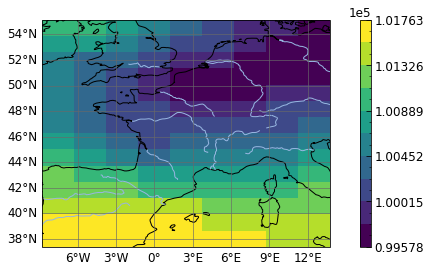

In [9]:
plotvar=edited_nf['pres'].sel(presnivs=1.002e+5, method='nearest')[0,:,:]
map_plotvar(plotvar)